In [2]:
from keras.applications import inception_v3
import keras.backend as K

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

Using TensorFlow backend.


In [0]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
# Create loss tensor
loss = K.variable(0.)

for layer_name in layer_contributions:
  # Add L2 norm of activations of the layer to the loss
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  loss += (coeff * 
                  K.sum(K.square(activation[:, 2:-2 , 2:-2, :])) / scaling)

In [0]:
# Our generated image
dream = model.input

# Compute and normalize gradient of image wrt loss
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)


# Set up function to retrieve loss and gradient given image
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_val = outs[0]
  grads_val = outs[1]
  return loss_val, grads_val

def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_val, grads_val = eval_loss_and_grads(x)
    if max_loss is not None and loss_val > max_loss:
      break
    print('--- Loss value at iteration %s : %s ---' % (i, loss_val))
    x += grads_val * step 
  return x

In [0]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
  img = np.copy(img)
  factors = (1,
            float(size[0]) / img.shape[1],
            float(size[1]) / img.shape[2],
            1)
  return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
  pil_img = deprocess_image(np.copy(img))
  return scipy.misc.imsave(fname, pil_img)

def preprocess_img(image_path):
  img = image.load_img(image_path)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img

def deprocess_img(x):
  if K.image_data_format() == 'channels_first':
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1, 2, 0))
  else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
  x /= 2.
  x += 0.5
  x*= 255.
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
import numpy as np

# Hyperparams

step = 0.01 # Gradient ascent step size
num_octave = 3
octave_scale = 1.4
iterations = 20 # Number of ascent steps per scale
max_loss = 10. # Short circuit if loss exceeds 10

base_image_path = 'img.png'

# Load image into a numpy array
img = preprocess_img(base_image_path)

# Prepare list of shape tuples to run gradient ascent at
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
  print('Processing image shape', shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img,
                       iterations=iterations,
                       step=step,
                       max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)
  save_img(img, fname='dream_at_scale_'+ str(shape) + '.png')

save_img(img, fname='finale_dream.png')

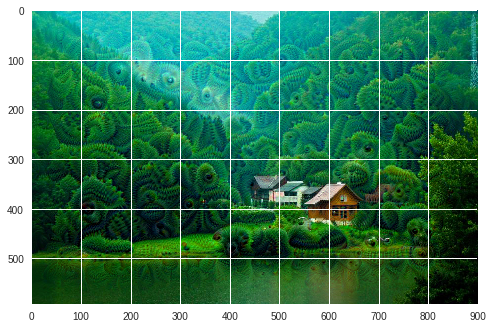

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fname = 'finale_dream.png'
img = mpimg.imread(fname)
plt.imshow(img)
plt.show()